The purpose of this notebook is to **analyze the subway stations according to their proportion of transfers in their ridership**. Data was created using the [Hourly subway ridership dataset](https://data.ny.gov/Transportation/MTA-Subway-Hourly-Ridership-2020-2024/wujg-7c2s/about_data). Note: transfers are only for out-of-system transfers and multi-modal transfers (bus->subway) -- between train transfers (from within the same station complex) are not included. 

# Imports

In [1]:
import pandas as pd
import seaborn as sns
import geopandas as gpd
from geodatasets import get_path
path_to_file = get_path('nybb')
import matplotlib.pyplot as plt
import requests

## API Request

In [2]:
api_endpoint = 'https://data.ny.gov/resource/wujg-7c2s.json?$query=SELECT%0A%20%20date_trunc_y(%60transit_timestamp%60)%20AS%20%60by_year_transit_timestamp%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20sum(%60ridership%60)%20AS%20%60sum_ridership%60%2C%0A%20%20sum(%60transfers%60)%20AS%20%60sum_transfers%60%0AWHERE%0A%20%20(%60transit_timestamp%60%0A%20%20%20%20%20BETWEEN%20%222024-12-09T00%3A00%3A00%22%20%3A%3A%20floating_timestamp%0A%20%20%20%20%20AND%20%222024-12-15T23%3A45%3A00%22%20%3A%3A%20floating_timestamp)%0A%20%20AND%20caseless_eq(%60transit_mode%60%2C%20%22subway%22)%0AGROUP%20BY%0A%20%20date_trunc_y(%60transit_timestamp%60)%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60'
response_data = None
if not response_data: 
    response = requests.get(api_endpoint)
response_data = response.json()
# the stations are separate from complexes by default
yearly_ridership_transfer_df = pd.DataFrame(response_data)

# Data Engineering

### Ridership Data

In [3]:
yearly_ridership_transfer_df.drop(columns='by_year_transit_timestamp', inplace=True)
#  Data type fixing 
for col in yearly_ridership_transfer_df.columns:
    if col != 'station_complex':
        yearly_ridership_transfer_df[col] = yearly_ridership_transfer_df[col].values.astype(dtype='float')

In [4]:
# merging into complexes 
stops_w_coords = yearly_ridership_transfer_df.groupby('station_complex_id')[['latitude', 'longitude']].mean().reset_index()
for row in range(len(yearly_ridership_transfer_df)):
    for complex_row in range(len(stops_w_coords)):
        if yearly_ridership_transfer_df.loc[row, 'station_complex_id'] == stops_w_coords.loc[complex_row, 'station_complex_id']:
            yearly_ridership_transfer_df.loc[row, 'latitude'] = stops_w_coords.loc[complex_row, 'latitude']
            yearly_ridership_transfer_df.loc[row, 'longitude'] = stops_w_coords.loc[complex_row, 'longitude']
complex_df = yearly_ridership_transfer_df.groupby('station_complex')[['sum_ridership', 'sum_transfers']].sum().reset_index()

In [5]:
for row in range(len(yearly_ridership_transfer_df)):
    for complex_row in range(len(complex_df)):
        if yearly_ridership_transfer_df.loc[row, 'station_complex'] == complex_df.loc[complex_row, 'station_complex']:
            yearly_ridership_transfer_df.loc[row, 'sum_ridership'] = complex_df.loc[complex_row, 'sum_ridership']
            yearly_ridership_transfer_df.loc[row, 'sum_transfers'] = complex_df.loc[complex_row, 'sum_transfers']
yearly_ridership_transfer_df.drop_duplicates(subset='station_complex', inplace=True)
yearly_ridership_transfer_df['transfer_ratio'] = round(yearly_ridership_transfer_df['sum_transfers'] \
                                                       / yearly_ridership_transfer_df['sum_ridership'], 3) * 2

In [6]:
transfer_gdf = gpd.GeoDataFrame(yearly_ridership_transfer_df, 
                                geometry=gpd.points_from_xy(yearly_ridership_transfer_df.longitude, 
                                                            yearly_ridership_transfer_df.latitude))
transfer_gdf.head(2)

,station_complex,station_complex_id,latitude,longitude,sum_ridership,sum_transfers,transfer_ratio,geometry
0,Vernon Blvd-Jackson Av (7),464.0,40.742626,-73.95358,84381.0,1381.0,0.032,POINT (-73.95358 40.74263)
1,Hunts Point Av (6),371.0,40.820950,-73.89055,39027.0,3145.0,0.162,POINT (-73.89055 40.82095)


### Geo Data

In [7]:
# from: https://geopandas.org/en/stable/docs/user_guide/geocoding.html?highlight=New%20York%20city#geocoding
boros = gpd.read_file(path_to_file)
boros = boros.to_crs(epsg=4326)
boros.drop(0, inplace=True) #removing staten island
transfer_gdf = transfer_gdf.set_crs(epsg=4326)

In [8]:
# from: https://geo.nyu.edu/catalog/nyu-2451-34758
lines_gdf = gpd.read_file("./data/nyu-2451-34758-shapefile/nyu_2451_34758.shp")
lines_gdf = lines_gdf[lines_gdf['route_id']!='SI']

In [9]:
# gdf_all = gpd.GeoDataFrame(transfer_gdf.merge(yearly_sorted, on='complex_id_str'))
# gdf_all = transfer_gdf.merge(stop_names_df, on='complex_id_str')
# gdf_all.dropna(how='any', axis=0, thresh=5, inplace=True)
# gdf_all.drop(columns=['complex_id_x', 'complex_id_y'], inplace=True)

# gdf_all['log_entries'] = np.log(gdf_all['entries'])
# gdf_all['square_root_entries'] = np.sqrt(gdf_all['entries'])

# Analysis

In [33]:
transfer_gdf = transfer_gdf.sort_values(by='transfer_ratio', ascending=False)
transfer_gdf.drop(columns=['latitude', 'longitude'], inplace=True)
transfer_gdf.head(20)

,station_complex,station_complex_id,sum_ridership,sum_transfers,transfer_ratio,geometry
183,Bay Pkwy (F),247.0,5150.0,1777.0,0.690,POINT (-73.97527 40.62077)
440,"Jamaica Center-Parsons/Archer (E,J,Z)",278.0,144463.0,48297.0,0.668,POINT (-73.80111 40.70215)
387,Jamaica-179 St (F),254.0,86284.0,27939.0,0.648,POINT (-73.78381 40.71265)
427,"Kew Gardens-Union Tpke (E,F)",259.0,105875.0,33973.0,0.642,POINT (-73.83101 40.71444)
97,Woodlawn (4),378.0,26469.0,7341.0,0.554,POINT (-73.87875 40.88604)
271,Flushing-Main St (7),447.0,303033.0,83393.0,0.550,POINT (-73.83003 40.7596)
320,Pelham Bay Park (6),360.0,25552.0,6266.0,0.490,POINT (-73.82812 40.85246)
227,Middle Village-Metropolitan Av (M),108.0,18650.0,4333.0,0.464,POINT (-73.8896 40.7114)
156,86 St (R),38.0,62390.0,13342.0,0.428,POINT (-74.0284 40.62269)
56,Van Cortlandt Park-242 St (1),293.0,26654.0,5658.0,0.424,POINT (-73.89858 40.88925)


In [34]:
transfer_gdf['transfer_ratio'].describe().round(3)

count    424.000
mean       0.085
std        0.110
min        0.002
25%        0.014
50%        0.045
75%        0.106
max        0.690
Name: transfer_ratio, dtype: float64

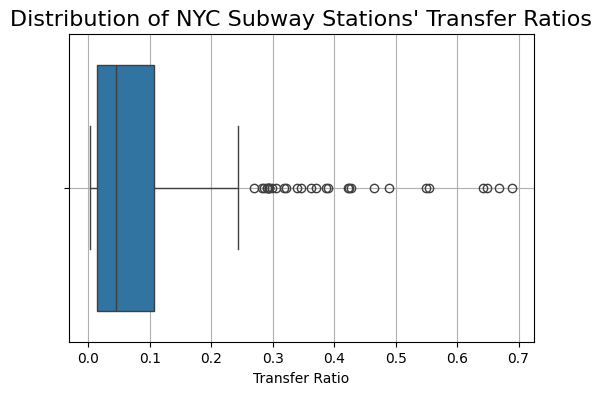

In [ ]:
fig, ax = plt.subplots(figsize=(6,4))
sns.boxplot(x=transfer_gdf['transfer_ratio'])
plt.grid()
plt.xlabel("Transfer Ratio")
plt.title("Distribution of NYC Subway Stations' Transfer Ratios",
             fontdict={'fontsize': '16','fontweight' : '2'})
# plt.savefig("./saved_data/distribution_of_station_transfer_ratios", dpi=50, bbox_inches='tight')

# Transfer Ratio Plots

### All Stations

<Axes: title={'center': 'Subway Station Transfer-to-Ridership Ratio in 2024'}>

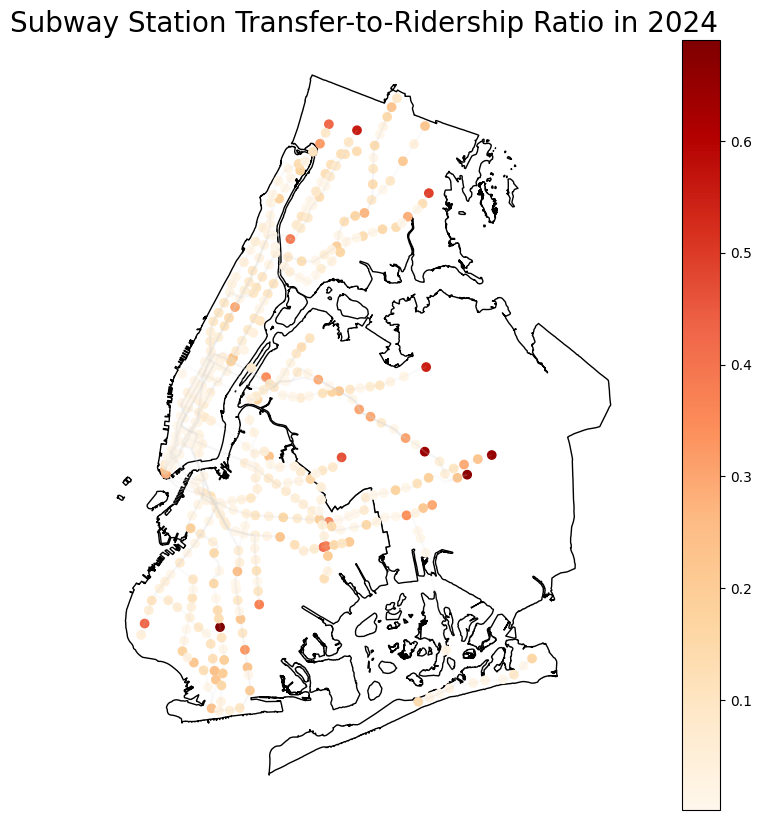

In [37]:
fig, ax = plt.subplots(figsize=(12,10))
boros.plot(ax=ax, color="white", edgecolor="black")
plt.axis('off')
plt.title('Subway Station Transfer-to-Ridership Ratio in 2024',
             fontdict={'fontsize': '20','fontweight' : '3'})
transfer_gdf.plot('transfer_ratio', ax=ax, legend=True, cmap='OrRd')
lines_gdf.plot(ax=ax, color='lightgray', alpha=0.1)
# plt.savefig("./saved_data/all_station_transfer_ratios", dpi=50, bbox_inches='tight')

### Top 20

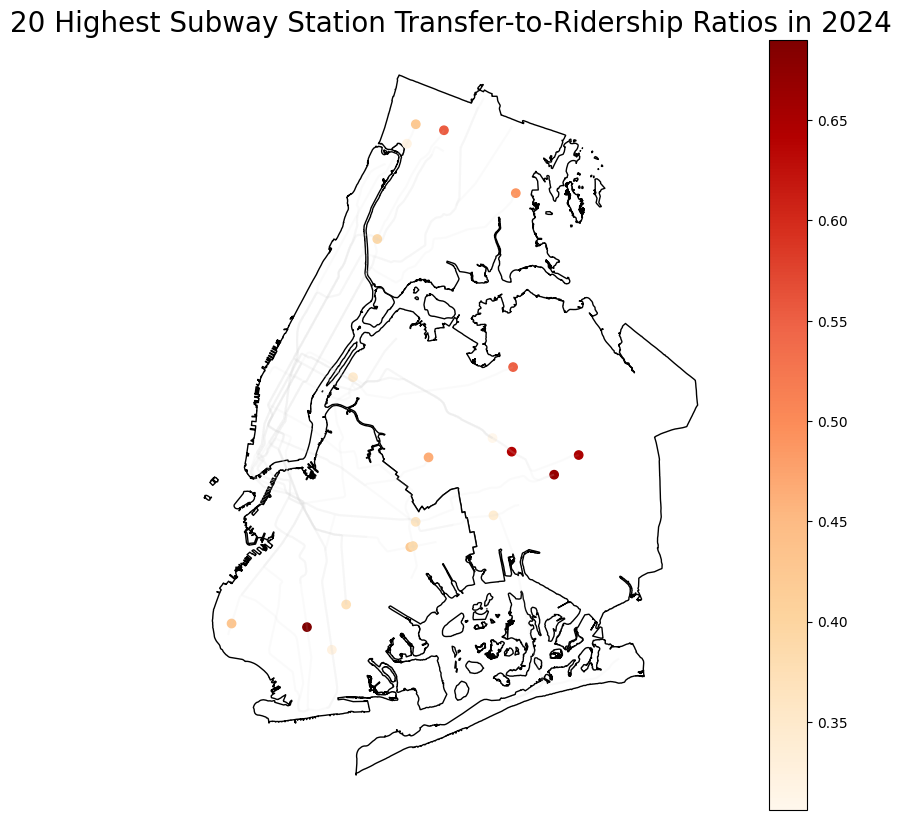

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
boros.plot(ax=ax, color="white", edgecolor="black")
plt.axis('off')
plt.title('20 Highest Subway Station Transfer-to-Ridership Ratios in 2024',
             fontdict={'fontsize': '20','fontweight' : '3'})
transfer_gdf[0:20].plot('transfer_ratio', ax=ax, legend=True, cmap='OrRd')
lines_gdf.plot(ax=ax, color='lightgray', alpha=0.1)
# plt.savefig("./saved_data/top_20_station_transfer_ratios", dpi=50, bbox_inches='tight')

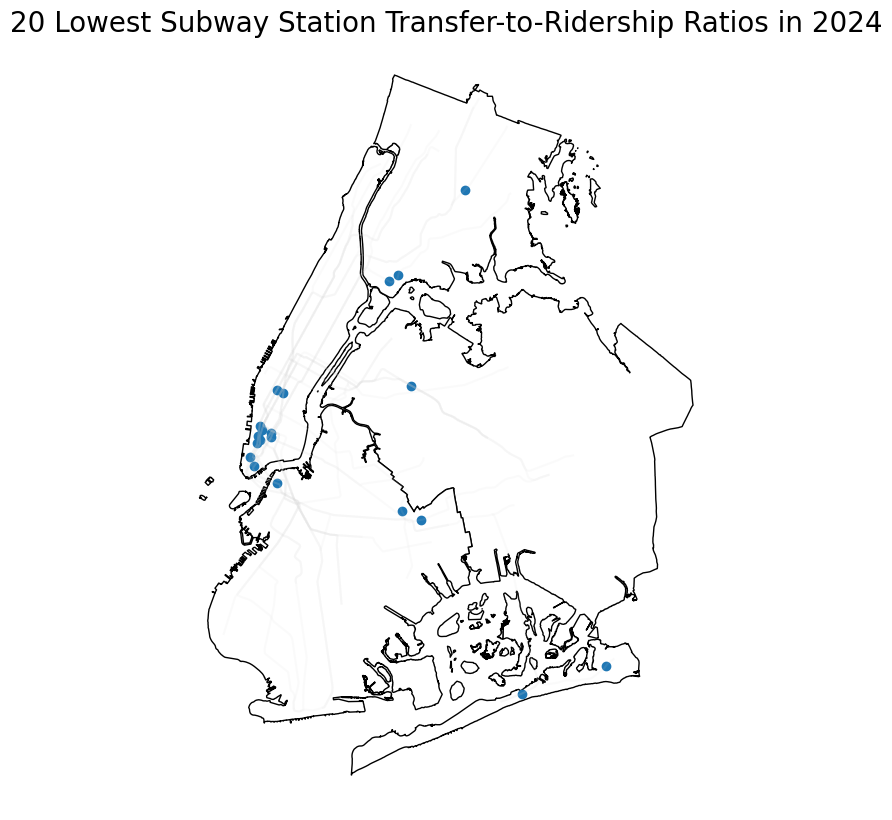

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
boros.plot(ax=ax, color="white", edgecolor="black")
plt.axis('off')
plt.title('20 Lowest Subway Station Transfer-to-Ridership Ratios in 2024',
             fontdict={'fontsize': '20','fontweight' : '3'})
transfer_gdf[-20:].plot(ax=ax)
lines_gdf.plot(ax=ax, color='lightgray', alpha=0.1)
# plt.savefig("./saved_data/bottom_20_station_transfer_ratios", dpi=50, bbox_inches='tight')

# Analysis of Payment Methods 
Are there more metrocard payments at high transfer ratio stations?

## Data

In [16]:
api_endpoint_payment = 'https://data.ny.gov/resource/wujg-7c2s.json?$query=SELECT%0A%20%20date_trunc_y(%60transit_timestamp%60)%20AS%20%60by_year_transit_timestamp%60%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60payment_method%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%2C%0A%20%20sum(%60transfers%60)%20AS%20%60sum_transfers%60%2C%0A%20%20sum(%60ridership%60)%20AS%20%60sum_ridership%60%0AGROUP%20BY%0A%20%20date_trunc_y(%60transit_timestamp%60)%2C%0A%20%20%60station_complex_id%60%2C%0A%20%20%60station_complex%60%2C%0A%20%20%60payment_method%60%2C%0A%20%20%60latitude%60%2C%0A%20%20%60longitude%60%0AHAVING%0A%20%20%60by_year_transit_timestamp%60%0A%20%20%20%20%3E%3D%20%222024-01-01T00%3A00%3A00%22%20%3A%3A%20floating_timestamp'
try: # only running if API hasn't been made yet 
    response_payment
except Exception as e:
    response_payment = requests.get(api_endpoint_payment)
    response_data_payment = response_payment.json()
# the stations are separate from complexes by default
payment_transfer_df = pd.DataFrame(response_data_payment)

In [17]:
payment_transfer_df.drop(columns='by_year_transit_timestamp', inplace=True)
payment_transfer_df = payment_transfer_df[~payment_transfer_df['station_complex_id'].str.contains("TRAM")]
#  Data type fixing 
for col in payment_transfer_df.columns:
    if col not in ['station_complex', 'payment_method']:
        payment_transfer_df[col] = payment_transfer_df[col].values.astype(dtype='float')

In [18]:
# do more people use omny or metrocard? -- pretty even split 
# 45% of transfers are made with metrocard and 43% of all riders use metrocard
payment_method_sum_df = payment_transfer_df.groupby('payment_method').sum()
payment_method_sum_df.drop(columns=['station_complex_id', 'station_complex', 'latitude'
                                    , 'longitude'], inplace=True)
payment_method_sum_df = payment_method_sum_df.T
payment_method_sum_df['metrocard_to_omny_ridership_ratio'] = payment_method_sum_df['metrocard'] /\
                                            (payment_method_sum_df['metrocard'] + payment_method_sum_df['omny'])
payment_method_sum_df

payment_method,metrocard,omny,metrocard_to_omny_ridership_ratio
sum_transfers,21793337.0,26704320.0,0.449369
sum_ridership,517534000.0,690617414.0,0.428368


In [19]:
# 4.2% of all metrocard users are transferring and 3.9% of all omny users are transferring
payment_method_sum_df.T['sum_transfers'] / payment_method_sum_df.T['sum_ridership']

payment_method
metrocard                            0.042110
omny                                 0.038667
metrocard_to_omny_ridership_ratio    1.049024
dtype: float64

In [20]:
# merging into complexes 
stops_w_coords_payment = payment_transfer_df.groupby('station_complex_id')[['latitude', 'longitude']].mean().reset_index()
for row in range(len(payment_transfer_df)):
    for complex_row in range(len(stops_w_coords_payment)):
        if payment_transfer_df.loc[row, 'station_complex_id'] == stops_w_coords_payment.loc[complex_row, 'station_complex_id']:
            payment_transfer_df.loc[row, 'latitude'] = stops_w_coords_payment.loc[complex_row, 'latitude']
            payment_transfer_df.loc[row, 'longitude'] = stops_w_coords_payment.loc[complex_row, 'longitude']
complex_df_payment = payment_transfer_df.groupby(['station_complex', 'payment_method'])[['sum_ridership', 'sum_transfers']].sum().reset_index()
complex_df_payment['transfer_ratio_by_payment'] = round(complex_df_payment['sum_transfers'] 
                                                        / complex_df_payment['sum_ridership'], 3)

In [21]:
van_total_transfers = 218964 + 54066.0	
218964 / van_total_transfers
# 54066.0	/ van_total_transfers

0.8019778046368531

In [22]:
# I should get the number of transfers by type
### van cortlandt has 80% of transfers being done by metrocard 
## the ratio only shows +0.125

In [23]:
complex_df_payment_raw_transfers = complex_df_payment.pivot(index='payment_method', columns='station_complex'
                                                            , values='sum_transfers').T.reset_index()
complex_df_payment_raw_transfers['transfer_type_diff'] = complex_df_payment_raw_transfers['metrocard'] \
                                                         - complex_df_payment_raw_transfers['omny']
complex_df_payment_raw_transfers['transfer_ratio_by_payment'] = round(complex_df_payment_raw_transfers['metrocard'] / \
                                    (complex_df_payment_raw_transfers['metrocard'] + complex_df_payment_raw_transfers['omny']), 3)

In [24]:
## a third of stations have more metrocard transfers than omny transfers
# complex_df_payment_raw_transfers[complex_df_payment_raw_transfers['transfer_type_diff'] > 0].count()

In [25]:
## Not terribly correlated with top and bottom transfers results
# complex_df_payment_raw_transfers.sort_values(by='transfer_type_diff')
complex_df_payment_raw_transfers.sort_values(by='transfer_ratio_by_payment')

payment_method,station_complex,metrocard,omny,transfer_type_diff,transfer_ratio_by_payment
390,Spring St (6),1245.0,6278.0,-5033.0,0.165
213,"Canal St (A,C,E)",1450.0,7346.0,-5896.0,0.165
78,"28 St (R,W)",1585.0,7369.0,-5784.0,0.177
391,"Spring St (C,E)",1055.0,4297.0,-3242.0,0.197
212,Canal St (1),266.0,1071.0,-805.0,0.199
...,...,...,...,...,...
354,"Norwood Av (J,Z)",2013.0,601.0,1412.0,0.770
405,Van Cortlandt Park-242 St (1),218964.0,54066.0,164898.0,0.802
423,Woodlawn (4),275074.0,64052.0,211022.0,0.811
91,"36 St (M,R)",6705.0,1239.0,5466.0,0.844


In [26]:
complex_df_payment_raw_transfers['transfer_ratio_by_payment'].mean()

np.float64(0.45048591549295774)

In [27]:
complex_df_payment_raw_transfers[complex_df_payment_raw_transfers['station_complex'].str.contains("Mott")]

payment_method,station_complex,metrocard,omny,transfer_type_diff,transfer_ratio_by_payment
259,Far Rockaway-Mott Av (A),58322.0,21901.0,36421.0,0.727


In [28]:
payment_ratio_df = complex_df_payment.pivot(index='station_complex', columns='payment_method'
                         , values='transfer_ratio_by_payment').reset_index()
payment_ratio_df['payment_ratio_diff'] = payment_ratio_df['metrocard'] - payment_ratio_df['omny']
# most stations have transfers via metrocard
# sns.boxplot(payment_ratio_df, y='payment_ratio_diff')
payment_ratio_df['high_diff'] = [True if abs(x) > 0.03 else False 
                                 for x in payment_ratio_df['payment_ratio_diff']]

In [29]:
payment_ratio_gdf_pre = pd.merge(left=payment_ratio_df, right=payment_transfer_df, on='station_complex')
payment_ratio_gdf_pre.drop(columns=['sum_transfers', 'sum_ridership', 'payment_method']
                           , inplace=True)
payment_ratio_gdf_pre.drop_duplicates(inplace=True)
payment_ratio_gdf = gpd.GeoDataFrame(payment_ratio_gdf_pre, 
                                geometry=gpd.points_from_xy(payment_ratio_gdf_pre.longitude, 
                                                            payment_ratio_gdf_pre.latitude))
payment_ratio_gdf_sorted = payment_ratio_gdf[payment_ratio_gdf['high_diff']==True].sort_values(by='payment_ratio_diff')

In [30]:
# This shows proportion of riders who switch using metrocard or omny and how they differ
# non terminal stations are more omny focused (people find using omny easier for transfers)
# terminal stations are metrocard focused (necessary for Bee-Line transfers)
payment_ratio_df[payment_ratio_df['high_diff']==True].sort_values(by='payment_ratio_diff')[0:5]

payment_method,station_complex,metrocard,omny,payment_ratio_diff,high_diff
173,Bay Pkwy (F),0.247,0.444,-0.197,True
309,Junius St (3),0.156,0.342,-0.186,True
62,21 St-Queensbridge (F),0.105,0.261,-0.156,True
310,"Kew Gardens-Union Tpke (E,F)",0.246,0.394,-0.148,True
263,Flushing-Main St (7),0.203,0.337,-0.134,True


In [31]:
payment_ratio_df[payment_ratio_df['high_diff']==True].sort_values(by='payment_ratio_diff')[-5:]

payment_method,station_complex,metrocard,omny,payment_ratio_diff,high_diff
259,Far Rockaway-Mott Av (A),0.098,0.055,0.043,True
254,Eastchester-Dyre Av (5),0.123,0.075,0.048,True
413,Wakefield-241 St (2),0.059,0.003,0.056,True
423,Woodlawn (4),0.286,0.166,0.120,True
405,Van Cortlandt Park-242 St (1),0.233,0.108,0.125,True


## Map 

<Axes: >

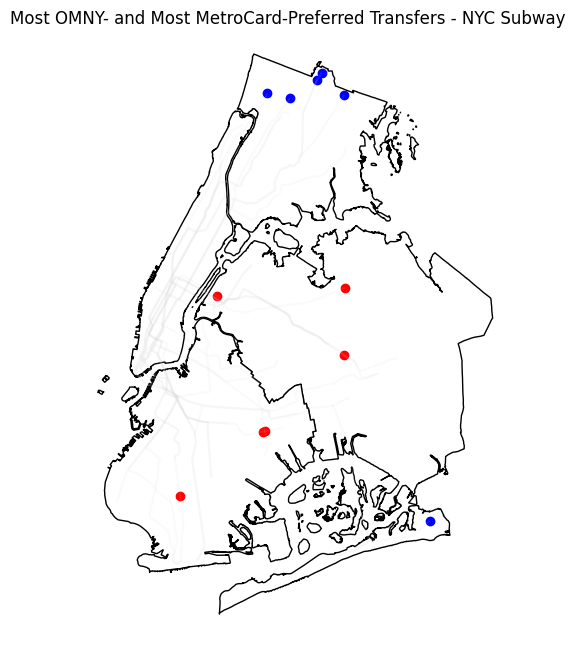

In [32]:
# show the stations' payment method of choice for transfers 
## use diverging continuous scales to do so
fig, ax = plt.subplots(figsize=(6,8))
boros.plot(ax=ax, color="white", edgecolor="black")
plt.axis('off')
# The transfer ratio of omny subtracted from the transfer ratio of metrocard riders
plt.suptitle('Most OMNY- and Most MetroCard-Preferred Transfers - NYC Subway',
             fontdict={'fontsize': '20','fontweight' : '3'}, y=0.9)
payment_ratio_gdf_sorted[-6:].plot(color='Blue', ax=ax)
payment_ratio_gdf_sorted[:6].plot(color='Red',ax=ax)
lines_gdf.plot(ax=ax, color='lightgray', alpha=0.1)
# plt.savefig("./saved_data/station_transfer_ratios_by_payment", dpi=50, bbox_inches='tight')